# **Video Classification with Transformers:**

**TeamGeekSquad**

Description: Training a video classifier with hybrid transformers.

we will be using a Transformer-based model - https://arxiv.org/abs/1706.03762 to classify videos.



In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


## **Data Collection**

we will be using a subsampled version of the
[UCF101 dataset](https://www.crcv.ucf.edu/data/UCF101.php),
a well-known benchmark dataset.

In [ ]:
!wget -q https://git.io/JGc31 -O ucf101_top5.tar.gz
!tar xf ucf101_top5.tar.gz

## **Installing and Importing Libraries**

In [ ]:
! pip install mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.0/25.0 MB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.6/147.6 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.1/106.1 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 7.3 MB/s eta 0:00:00
  Attempting uninst

## **Setting up MLOPS**

In [ ]:
pip install databricks-cli

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 4.8 MB/s eta 0:00:00


In [ ]:
!databricks configure --host https://community.cloud.databricks.com/

Username: suresh.ravuri@sjsu.edu
Password: 
Repeat for confirmation: 


In [ ]:
import mlflow

mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/Users/suresh.ravuri@sjsu.edu/Deep-Learning-Project")

2024/05/20 08:44:10 INFO mlflow.tracking.fluent: Experiment with name '/Users/suresh.ravuri@sjsu.edu/Deep-Learning-Project' does not exist. Creating a new experiment.


<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/3160353700836913', creation_time=1716194650957, experiment_id='3160353700836913', last_update_time=1716194650957, lifecycle_stage='active', name='/Users/suresh.ravuri@sjsu.edu/Deep-Learning-Project', tags={'mlflow.experiment.sourceName': '/Users/suresh.ravuri@sjsu.edu/Deep-Learning-Project',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'suresh.ravuri@sjsu.edu',
 'mlflow.ownerId': '5741635163592177'}>

In [ ]:
# running experiment
current_run = mlflow.start_run()
mlflow.sklearn.autolog()

In [ ]:
from tensorflow_docs.vis import embed
from tensorflow.keras import layers
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

## **Define hyperparameters**

In [ ]:
MAX_SEQ_LENGTH = 20
NUM_FEATURES = 1024
IMG_SIZE = 128
EPOCHS = 10

In [ ]:
mlflow.log_param("MAX_SEQ_LENGTH",MAX_SEQ_LENGTH)
mlflow.log_param("NUM_FEATURES",NUM_FEATURES)
mlflow.log_param("IMG_SIZE",IMG_SIZE)
mlflow.log_param("EPOCHS",EPOCHS)

10

## **Data preparation**

We will mostly be following the same data preparation steps in this example, except for
the following changes:

* We reduce the image size to 128x128 instead of 224x224 to speed up computation.
* Instead of using a pre-trained [InceptionV3](https://arxiv.org/abs/1512.00567) network,
we use a pre-trained
[DenseNet121](http://openaccess.thecvf.com/content_cvpr_2017/papers/Huang_Densely_Connected_Convolutional_CVPR_2017_paper.pdf)
for feature extraction.
* We directly pad shorter videos to length `MAX_SEQ_LENGTH`.

In [ ]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

center_crop_layer = layers.CenterCrop(IMG_SIZE, IMG_SIZE)


def crop_center(frame):
    cropped = center_crop_layer(frame[None, ...])
    cropped = cropped.numpy().squeeze()
    return cropped


def load_video(path, max_frames=0):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center(frame)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)


def build_feature_extractor():
    feature_extractor = keras.applications.DenseNet121(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.densenet.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()


# Label preprocessing with StringLookup.
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"]), mask_token=None
)
print(label_processor.get_vocabulary())


def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_features` are what we will feed to our sequence model.
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))

        # Pad shorter videos.
        if len(frames) < MAX_SEQ_LENGTH:
            diff = MAX_SEQ_LENGTH - len(frames)
            padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
            frames = np.concatenate(frames, padding)

        frames = frames[None, ...]

        # Initialize placeholder to store the features of the current video.
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                if np.mean(batch[j, :]) > 0.0:
                    temp_frame_features[i, j, :] = feature_extractor.predict(
                        batch[None, j, :]
                    )

                else:
                    temp_frame_features[i, j, :] = 0.0

        frame_features[idx,] = temp_frame_features.squeeze()

    return frame_features, labels

Total videos for training: 594
Total videos for testing: 224
29084464/29084464 [==============================] - 2s 0us/step
['CricketShot', 'PlayingCello', 'Punch', 'ShavingBeard', 'TennisSwing']


In [ ]:
!wget -q https://git.io/JZmf4 -O top5_data_prepared.tar.gz
!tar xf top5_data_prepared.tar.gz

In [ ]:
train_data, train_labels = np.load("train_data.npy"), np.load("train_labels.npy")
test_data, test_labels = np.load("test_data.npy"), np.load("test_labels.npy")

print(f"Frame features in train set: {train_data.shape}")

Frame features in train set: (594, 20, 1024)


## **Building the Transformer-based model**

First, self-attention layers that form the basic blocks of a Transformer are
order-agnostic. Since videos are ordered sequences of frames, we need our
Transformer model to take into account order information.
We do this via **positional encoding**.
We simply embed the positions of the frames present inside videos with an
[`Embedding` layer](https://keras.io/api/layers/core_layers/embedding). We then
add these positional embeddings to the precomputed CNN feature maps.

In [ ]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.output_dim = output_dim

    def call(self, inputs):
        # The inputs are of shape: `(batch_size, frames, num_features)`
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions

    def compute_mask(self, inputs, mask=None):
        mask = tf.reduce_any(tf.cast(inputs, "bool"), axis=-1)
        return mask

Now, we can create a subclassed layer for the Transformer.

In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.3
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation=tf.nn.gelu), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]

        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

## **Utility functions for training**

In [ ]:
def get_compiled_model():
    sequence_length = MAX_SEQ_LENGTH
    embed_dim = NUM_FEATURES
    dense_dim = 4
    num_heads = 1
    classes = len(label_processor.get_vocabulary())

    inputs = keras.Input(shape=(None, None))
    x = PositionalEmbedding(
        sequence_length, embed_dim, name="frame_position_embedding"
    )(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model


def run_experiment():
    filepath = "/content/model_weights/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    model = get_compiled_model()

    history = model.fit(
        train_data,
        train_labels,
        validation_split=0.15,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )



    model.load_weights(filepath)
    _, accuracy = model.evaluate(test_data, test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    mlflow.log_param("Test accuracy",round(accuracy * 100, 2))

    return model


## **Model training and inference**

In [ ]:
trained_model = run_experiment()

Epoch 1/10
13/16 [=======================>......] - ETA: 0s - loss: 3.0993 - accuracy: 0.5240
Epoch 1: val_loss improved from inf to 3.13753, saving model to /content/model_weights/video_classifier
16/16 [==============================] - 7s 53ms/step - loss: 2.6514 - accuracy: 0.5774 - val_loss: 3.1375 - val_accuracy: 0.0111
Epoch 2/10
13/16 [=======================>......] - ETA: 0s - loss: 0.4102 - accuracy: 0.8966
Epoch 2: val_loss improved from 3.13753 to 0.66808, saving model to /content/model_weights/video_classifier
16/16 [==============================] - 0s 29ms/step - loss: 0.3895 - accuracy: 0.9048 - val_loss: 0.6681 - val_accuracy: 0.8222
Epoch 3/10
13/16 [=======================>......] - ETA: 0s - loss: 0.0916 - accuracy: 0.9712
Epoch 3: val_loss did not improve from 0.66808
16/16 [==============================] - 0s 16ms/step - loss: 0.0779 - accuracy: 0.9762 - val_loss: 1.0725 - val_accuracy: 0.7111
Epoch 4/10
16/16 [==============================] - ETA: 0s - loss: 0

**Note:** This model has ~4.23 Million parameters, which is way more than the sequence model (99918 parameters) we used in the prequel of this example. This kind of Transformer model works best with a larger dataset and a longer pre-training schedule.

In [ ]:
mlflow.end_run()

Test video path: v_Punch_g05_c03.avi
1/1 [==============================] - 0s 20ms/step
  Punch: 100.00%
  PlayingCello:  0.00%
  TennisSwing:  0.00%
  ShavingBeard:  0.00%
  CricketShot:  0.00%



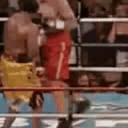

In [ ]:

def prepare_single_video(frames):
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    # Pad shorter videos.
    if len(frames) < MAX_SEQ_LENGTH:
        diff = MAX_SEQ_LENGTH - len(frames)
        padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
        frames = np.concatenate(frames, padding)

    frames = frames[None, ...]

    # Extract features from the frames of the current video.
    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            if np.mean(batch[j, :]) > 0.0:
                frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
            else:
                frame_features[i, j, :] = 0.0

    return frame_features


def predict_action(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features = prepare_single_video(frames)
    probabilities = trained_model.predict(frame_features)[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames



def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = predict_action(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])